### Import necessary libraries

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model, Model, Sequential

from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.resnet import ResNet101
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers, regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import DistanceMetric, confusion_matrix, accuracy_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay

import gym
from gym import spaces

In [2]:
def test_model(model, val_X, val_Y, class_names):
    
    preds = model.predict(val_X)
    # Convert predicted probabilities to predicted class labels
    pred_labels = []
    for pl in preds:
        x = np.zeros(len(class_names), dtype="int8")
        x[np.argmax(pl)] = 1
        pred_labels.append(x)
    p_l = [np.where(x == 1)[0][0] if np.where(x == 1)[0].size > 0 else 0 for x in pred_labels]
    t_l = [np.where(x == 1)[0][0] for x in val_Y]
    
    accuracy = accuracy_score(val_Y, pred_labels)
    
    # Calculate precision
    precision = precision_score(val_Y, pred_labels, average='micro')
    
    # Calculate F1 score
    f1 = f1_score(val_Y, pred_labels, average='micro')
    
    # Calculate AUC-ROC
    auc_roc = roc_auc_score(val_Y, pred_labels, average='micro')
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(t_l, p_l)
    
    
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix')
    plt.show()
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("F1 Score:", f1)
    print("AUC-ROC Score:", auc_roc)
    print("Confusion Matrix:")
    print(conf_matrix)

### Define MyEnv class

In [3]:
class MyEnv(gym.Env):
    def __init__(self, images, labels):
        # super(myEnv, self).__init__()
        self.timestep_limit = len(labels) or 100
        self.images = images
        self.labels = labels
        self.num_classes = len(np.unique(labels))
        self.action_space = spaces.Discrete(self.num_classes)
        self.observation_space = spaces.Box(low=0, high=255, shape=images[0].shape, dtype=np.uint8)
        self.current_step = 0
    
    def reset(self):
        self.current_step = 0
        obs = self.images[self.current_step]
        return obs
    
    def step(self, action):
        reward = self._get_reward(action)
        done = self.current_step == len(self.images) - 1
        obs = self.images[self.current_step]
        self.current_step += 1
        return obs, reward, done, {}
    
    def _get_reward(self, action):
        if np.argmax(action) == np.argmax(self.labels[self.current_step]):
            return 1
        else:
            return -1


### Define Dataloader Base class to load image data

In [4]:
class DataLoaderBase:
    def __init__(self, dataset_path, image_size=(224, 224), batch_size=64, data_size = 0):
        self.dataset_path = dataset_path
        self.config = { "image_size": image_size, "batch_size": batch_size }
        # define ImageDataGenerator object for lading image data
        self.data_gen = ImageDataGenerator(
          rescale=1./255,
          width_shift_range=0.1,
          height_shift_range=0.1,
          # shear_range=0.1,
          zoom_range=0.2,
          # horizontal_flip=True,
          fill_mode='nearest',
          validation_split=(1-data_size)
        )
        self.data = self.data_gen.flow_from_directory(
          self.dataset_path,
          subset="training", # using this param just to get the selected portion of total dataset
          class_mode='categorical', # 'sparse', # 'categorical'
          target_size=self.config['image_size'],
          batch_size=self.config['batch_size'],
          shuffle=True,
        )
        self.num_classes = self.data.num_classes
        self.class_names = list(self.data.class_indices.keys())
        print("Total classes:", self.num_classes, self.class_names)

        self.images, self.labels = [], []
        print("{} Preparing Data {}".format('#'*15, '#'*15))
        for idx in range(len(self.data)):
            batch_X, batch_Y = self.data.next()
            self.images.append(batch_X)
            self.labels.append(batch_Y)
        
        self.images = np.concatenate(self.images)
        self.labels = [x.astype(np.int8) for x in np.concatenate(self.labels)] # converting [0.0 1.0 0.0] => [0 1 0]
        print("{} Data Preparation completed {}".format('#'*15, '#'*15))

### Define Expert Class

In [5]:
class Expert(DataLoaderBase):

    def __init__(self, image_size, batch_size, dataset_size, is_human_expert):
        dataset_path = "../../dataset/ctscan/3A_images_resized/expert_dataset/train"
        model_path = "./models/ctscan_vgg16net_64_20_expert_acc_99.3.h5"
        DataLoaderBase.__init__(self, dataset_path, image_size, batch_size, dataset_size)
        self.config["is_human_expert"] = is_human_expert
        self.n_rollouts = 2
        self.model = load_model(model_path)

    def policy_fn(self, input, data_idx):
        expert_output = [0, 0, 0]
        if self.config["is_human_expert"]: # human expert
            # just returning output based on predefined label
            expert_output = self.labels[data_idx]
            return expert_output
        else: # using pretrained expert model
            expert_output = np.zeros(self.num_classes, dtype="int8") # [0, 0, 0]
            predictions = self.model.predict(input, verbose=0) # [[0.01, 0.98, 0.32]]
            predicted_index = np.argmax(predictions[0])
            expert_output[predicted_index] = 1
            return expert_output
        
    def get_demonstrations(self):
        # read normalized image data and labels from demo_generator
        env = MyEnv(self.images, self.labels)
        
        max_steps = env.timestep_limit

        observations, actions, rewards = [], [], []

        # Demonstrating the expert
        print("Preparing demonstration data by expert")
        for rollout in range(1, self.n_rollouts):
            # predict on bulk if pretained expert model is being used
            if self.config['is_human_expert']:
                predictions = self.model.predict(self.images) # [[0.01, 0.98, 0.32], [0.71, 0.098, 0.032]]
                
                obs = env.reset()
                
                done, total_reward, steps = False, 0, 0
                while not done:
                    action = self.policy_fn(obs[None,:], env.current_step)
                    obs, reward, done, _ = env.step(action)
                    observations.append(obs)
                    actions.append(action)
                    total_reward += reward
                    steps += 1
                    if steps % 100 == 0:
                        print("%i/%i"%(steps, max_steps))
                    if steps >= max_steps:
                        break
                rewards.append(total_reward)
            else:
                observations.extend(self.images)
                predictions = self.model.predict(self.images) # [[0.01, 0.98, 0.32], [0.71, 0.098, 0.032]]
                actions_temp = []
                reward_temp = 0
                for i, pred in enumerate(predictions):
                    output_temp = np.zeros(self.num_classes, dtype="int8") # [0, 0, 0]
                    predicted_index = np.argmax(pred)
                    output_temp[predicted_index] = 1
                    actions_temp.append(output_temp)
                    if predicted_index == np.argmax(self.labels[i]):
                        reward_temp += 1
                actions.extend(actions_temp)
                rewards.append(reward_temp)
                
        print("Expert reward: {}".format(np.average(rewards)))
        print("Expert expected reward: {}".format(len(self.labels)))
        return {"observations": np.array(observations), "actions": np.array(actions)}

### Define DAgger class

In [21]:
class DAgger(DataLoaderBase):

    def __init__(self, expert, image_size, batch_size, dataset_size = 1):
        dataset_path = "../../dataset/ctscan/3A_images_resized/new_dataset/test"
        DataLoaderBase.__init__(self, dataset_path, image_size, batch_size, dataset_size)
        self.config["is_human_expert"] = expert.config['is_human_expert']
        self.curr_state = expert.get_demonstrations()
        self.surr_loss = DistanceMetric.get_metric('euclidean')
        self.train_X, self.test_X, self.train_Y, self.test_Y = train_test_split(self.images, self.labels, test_size=0.3, shuffle=True)
        self.new_data_batch = int(len(self.train_Y)/9)
        self.train_epochs = 10
        self.n_rollouts = int(len(self.train_Y)/self.new_data_batch) + 1
        self.p = 0.9 # probability of using the expert (value recommended on section 5 of https://arxiv.org/pdf/1011.0686.pdf)
        
        # to query the expert, defining expert
        self.expert_policy = self.expert_policy() if self.config["is_human_expert"] else expert.model

    def score_policy(self, model):
        predicted_actions = model.predict(self.test_X)
        expected_actions = np.array(self.test_Y)
        scores = []
        for i in range(len(predicted_actions)):
            score = self.surr_loss.pairwise([predicted_actions[i]], [expected_actions[i]])
            scores.append(score)
        return np.mean(scores)

    def expert_policy(self):
        # this train the mod
        # expert_model = self.train_model(self.base_model(), True)
        # expert_model.save("./models/expert_policy.h5")
        expert_model = lambda acts: np.array(acts)
        return expert_model
    
    def train(self):

        self.build_network()
        print("Imitating expert observations....")
        # mimicing the expert's feature
        self.dagger_policy = self.train_model(self.dagger_policy)
        print("Imitating expert observations DONE!!!")
        best_score, best_dagger_model = self.score_policy(self.dagger_policy), self.dagger_policy
        print("Initial Best score: ", best_score)

        '''
        dagger_model = self.train_model(self.dagger_policy)
        
        score = self.score_policy(dagger_model)
        print("New Policy Score:", score)

        if score < best_score:
            best_score = score
            best_dagger_model = dagger_model
        print("New Best Policy Score:",  best_score)
        '''
        return best_dagger_model

    def base_model(self):
        input_shape = self.config['image_size']
        # choose one of the base models
        base_model = VGG16(input_shape=input_shape + (3,), include_top=False, weights ='imagenet')
        # base_model = ResNet101(input_shape=input_shape, include_top=False, weights='imagenet')
        # base_model = DenseNet169(input_shape=input_shape, include_top=False, weights ='imagenet')

        # freeze layers of base model as training is not needed for them
        for layer in base_model.layers:
          layer.trainable = False

        '''
        # Make some customization on the output layer of base Model
        x = base_model.output
        # x = GlobalAveragePooling2D()(x)
        # x = MaxPooling2D()(x)
        # x = Dense(1024, activation='relu')(x)
        x = Flatten()(x)

        x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.02))(x)
        x = Dropout(0.5)(x)
        predictions = Dense(self.num_classes, activation='softmax')(x)

        # Initialize model based on base Model
        model = Model(inputs=base_model.input, outputs=predictions)
        '''
        model = Sequential([
            base_model,
            Flatten(),
            Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            Dropout(0.5),  # Add dropout layer for regularization
            Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            Dropout(0.5),  # Add dropout layer for regularization
            Dense(self.num_classes, activation='softmax')
        ])

        # Compile model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def build_network(self):
        self.dagger_policy = self.base_model()
        '''
        self.dagger_policy = Sequential([
            # Convolutional layers
            Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            
            # Flatten the output of the convolutional layers
            Flatten(),
            
            # Fully connected layers
            Dense(64, activation='relu'),
            Dense(self.num_classes, activation='softmax')  # Output layer with number of classes
        ])
        self.dagger_policy.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        '''

    def train_model(self, model, is_expert=False):
        t_X, t_Y = self.curr_state['observations'], self.curr_state['actions']

        # adjusting class weights
        y_labels = [np.where(x == 1)[0][0] if np.where(x == 1)[0].size > 0 else 0 for x in t_Y]
        train_data_distribution = np.unique(y_labels, return_counts=True)
        class_weight = {key: train_data_distribution[1][key] for key in train_data_distribution[0]}
        print("Default class weight: {}".format(class_weight))
        
        # class_weight = { key: class_weight[0]/class_weight[key] for key in class_weight.keys() }
        # print("Balanced class weight: {}".format(class_weight))
        
        # # customizing the weights
        # class_weight = {0: class_weight[0]*1.1, 1: class_weight[1] * 1.2, 2: class_weight[2]}
        # print("Custom class weight: {}".format(class_weight))

        history = model.fit(t_X, t_Y, epochs=self.train_epochs, batch_size=self.config['batch_size'], validation_split=0.2, shuffle=True, class_weight=class_weight)
       
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        return model

    def main(self):
        # training model with initial observations from expert
        learned_policy = self.train()

        # Initial test
        print("{} Testing learned model demons by expert {}".format('#'*15, '#'*15))
        test_model(learned_policy, self.test_X, self.test_Y, self.class_names)
        print("{} Testing learned model demons by expert DONE {}\n\n\n".format('*'*15, '*'*15))
        
        reward_dict = {}
        
        # aggregating data and retraining
        for rollout in range(1, self.n_rollouts + 1):
            print("{} Rollout: {} of {} {}".format('#'*15, rollout, self.n_rollouts, '#'*15))

            beta = 1 if rollout == 1 else self.p**(rollout - 1)
            print("Value of beta: {}".format(beta))
            
            current_policy = lambda is_human_expert, obs, acts: beta * (self.expert_policy(acts) if is_human_expert else self.expert_policy.predict(obs, verbose=0)) + (1 - beta) * learned_policy.predict(obs)

            # generate new dataset (new trajectories)
            start_index = (rollout - 1) * self.new_data_batch
            end_index = start_index + self.new_data_batch
            new_images, new_labels = self.train_X[start_index:end_index], self.train_Y[start_index:end_index]
            new_observations = new_images
            
            trajectory_actions = current_policy(self.config["is_human_expert"], new_observations, new_labels)

            # prepare new dataset with the help of expert policy
            if self.config["is_human_expert"]:
                new_actions = self.expert_policy(new_labels)
            else:
                new_actions = self.expert_policy.predict(new_observations, verbose=0) # [[0.01, 0.98, 0.32], [0.71, 0.098, 0.032]]
                new_actions = (new_actions > 0.5).astype(np.int8)

            # aggregating the data
            current_abservation_list =  list(self.curr_state["observations"])
            current_actions_list = list(self.curr_state["actions"])
            current_abservation_list.extend(new_observations)
            current_actions_list.extend(new_actions)
            self.curr_state["observations"] = np.array(current_abservation_list)
            self.curr_state["actions"] = np.array(current_actions_list)

            current_policy_preds = learned_policy.predict(new_observations, verbose=0)

            # evaluating expert's predictions and current policy's preds
            actions_temp, new_rewards = [], []
            reward_temp, current_count = 0, 0
            distribution_info = {"0": 0, "1": 0, "2": 0}
            for i, expert_pred in enumerate(new_actions):
                if np.argmax(new_labels[i]) == 0:
                    distribution_info['0'] += 1
                elif np.argmax(new_labels[i]) == 1:
                    distribution_info['1'] += 1
                else:
                    distribution_info['2'] += 1
                
                predicted_index = np.argmax(expert_pred)
                if predicted_index == np.argmax(new_labels[i]):
                    current_count += 1
                
                c_pred = current_policy_preds[i]
                c_pred_idx = np.argmax(c_pred)
                if c_pred_idx == np.argmax(new_labels[i]):
                    reward_temp += 1
            new_rewards.append(reward_temp)
            print("expert's accuracy = {}".format(current_count/len(new_labels)))

            # this is another way to add new data (one by one) but too slow
            '''
            env = MyEnv(new_images, new_labels)
            obs = env.reset()
            new_observations, new_actions, new_rewards = [], [], []
            
            done, total_reward, steps = False, 0, 0
            while not done:
                action = self.expert_policy(obs[None,:], env.current_step)
                new_observations.append(obs)
                new_actions.append(action)
                obs, reward, done, _ = env.step(action)
                total_reward += reward
                steps += 1
                if steps % 100 == 0:
                    print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
            new_rewards.append(total_reward)
            
            self.curr_state["observations"] = list(self.curr_state["observations"]).extend(new_observations)
            self.curr_state["actions"] = list(self.curr_state["actions"]).extend(new_actions)

            '''
            
            print(distribution_info)
            print("Training for rollout {} with {} of training data".format(rollout, len(self.curr_state["actions"])))
            learned_policy = self.train()
            print("Training completed for rollout {}".format(rollout))

            print("\n{} Testing learned model {}".format('#'*15, '#'*15))
            
            print("Reward: {}, Expected Reward: {}".format(np.mean(new_rewards), len(new_actions)))
            
            # calculate relative reward 
            reward_dict[rollout] = np.mean(new_rewards)/len(new_actions) * 100
            
            test_model(learned_policy, self.test_X, self.test_Y, self.class_names)
            print("{} Testing learned model done {}\n\n\n".format('*'*15, '*'*15))
            human_or_model = "human_expert" if self.config["is_human_expert"] else "model_expert"
            model_name = "./models/learned_policy_{}_rollout".format(human_or_model)
            learned_policy.save("{}_{}.h5".format(model_name, rollout))
        best_rollout = max(reward_dict, key=reward_dict.get)
        return "{}_{}.h5".format(model_name, best_rollout)

### Define some parameters

In [26]:
IMAGE_SIZE = (224, 224) # better to use same size as used in pretrained
BATCH_SIZE = 64
IS_HUMAN_EXPERT = False # flag whether to use pretained model or use simulated human
EXPERT_DATASET_SIZE = 0.5 # Total = 6063, take only x% data 
AGENT_DATASET_SIZE = 1 # Total = 8937 in train folder, 2000 in test folder, take only x% data

### Create an object of Expert

In [23]:
my_expert = Expert(IMAGE_SIZE, BATCH_SIZE, EXPERT_DATASET_SIZE, IS_HUMAN_EXPERT)

Found 3033 images belonging to 3 classes.
Total classes: 3 ['Covid19', 'Normal', 'Pneumonia']
############### Preparing Data ###############
############### Data Preparation completed ###############


### Create an object of DAgger

In [27]:
dagger = DAgger(my_expert, IMAGE_SIZE, BATCH_SIZE, AGENT_DATASET_SIZE)

Found 2000 images belonging to 3 classes.
Total classes: 3 ['Covid19', 'Normal', 'Pneumonia']
############### Preparing Data ###############
############### Data Preparation completed ###############
Preparing demonstration data by expert
95/95 [==============================] - 3s 35ms/step
Expert reward: 3032.0
Expert expected reward: 3033


### Train DAgger model

Imitating expert observations....
Default class weight: {0: 1010, 1: 1011, 2: 1012}
Epoch 1/10
38/38 [==============================] - 4s 96ms/step - loss: 1847.4183 - accuracy: 0.6257 - val_loss: 1.4156 - val_accuracy: 0.9423
Epoch 2/10
38/38 [==============================] - 3s 88ms/step - loss: 201.8917 - accuracy: 0.9221 - val_loss: 1.3411 - val_accuracy: 0.9852
Epoch 3/10
38/38 [==============================] - 3s 88ms/step - loss: 107.0121 - accuracy: 0.9625 - val_loss: 1.3493 - val_accuracy: 0.9918
Epoch 4/10
38/38 [==============================] - 3s 88ms/step - loss: 70.5574 - accuracy: 0.9736 - val_loss: 1.3492 - val_accuracy: 0.9951
Epoch 5/10
38/38 [==============================] - 3s 88ms/step - loss: 44.0332 - accuracy: 0.9835 - val_loss: 1.3855 - val_accuracy: 0.9868
Epoch 6/10
38/38 [==============================] - 3s 88ms/step - loss: 46.5007 - accuracy: 0.9843 - val_loss: 1.3687 - val_accuracy: 0.9951
Epoch 7/10
38/38 [==============================] - 3s 88ms/

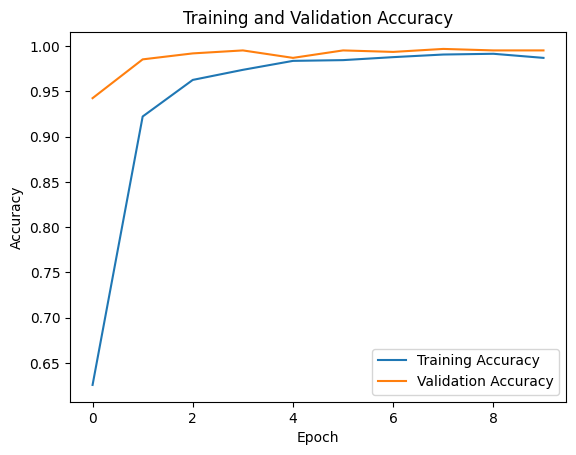

Imitating expert observations DONE!!!
19/19 [==============================] - 1s 35ms/step
Initial Best score:  0.1456524603144445
############### Testing learned model demons by expert ###############
19/19 [==============================] - 1s 36ms/step


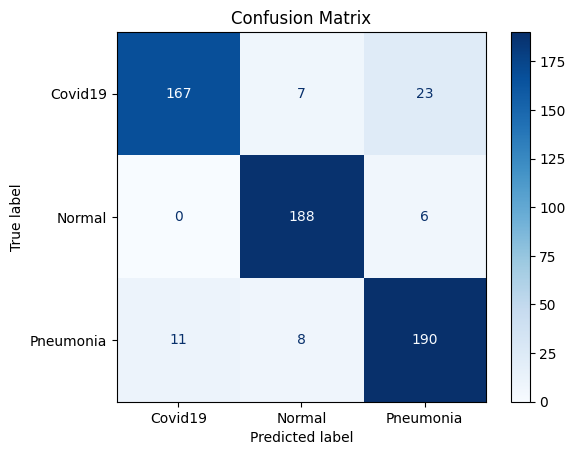

Accuracy: 0.9083333333333333
Precision: 0.9083333333333333
F1 Score: 0.9083333333333333
AUC-ROC Score: 0.93125
Confusion Matrix:
[[167   7  23]
 [  0 188   6]
 [ 11   8 190]]
*************** Testing learned model demons by expert DONE ***************



############### Rollout: 1 of 10 ###############
Value of beta: 1
5/5 [==============================] - 0s 35ms/step
expert's accuracy = 0.967741935483871
{'0': 56, '1': 51, '2': 48}
Training for rollout 1 with 3188 of training data
Imitating expert observations....
Default class weight: {0: 1062, 1: 1063, 2: 1063}
Epoch 1/10
40/40 [==============================] - 9s 217ms/step - loss: 1459.6705 - accuracy: 0.6922 - val_loss: 1.4203 - val_accuracy: 0.9122
Epoch 2/10
40/40 [==============================] - 4s 89ms/step - loss: 178.2888 - accuracy: 0.9333 - val_loss: 1.3506 - val_accuracy: 0.9530
Epoch 3/10
40/40 [==============================] - 4s 90ms/step - loss: 86.4554 - accuracy: 0.9722 - val_loss: 1.3364 - val_accuracy: 0.967

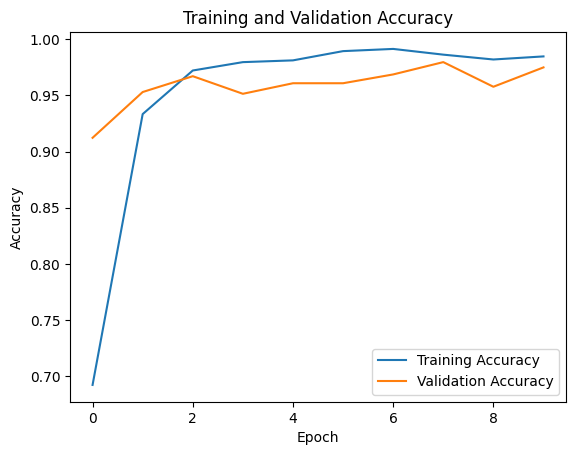

Imitating expert observations DONE!!!
19/19 [==============================] - 1s 36ms/step
Initial Best score:  0.14818060324686755
Training completed for rollout 1

############### Testing learned model ###############
Reward: 137.0, Expected Reward: 155
19/19 [==============================] - 1s 36ms/step


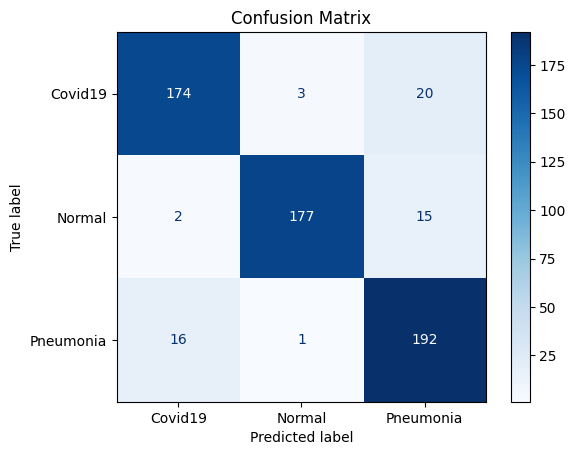

Accuracy: 0.905
Precision: 0.905
F1 Score: 0.905
AUC-ROC Score: 0.92875
Confusion Matrix:
[[174   3  20]
 [  2 177  15]
 [ 16   1 192]]
*************** Testing learned model done ***************



############### Rollout: 2 of 10 ###############
Value of beta: 0.9
5/5 [==============================] - 0s 36ms/step
expert's accuracy = 0.9483870967741935
{'0': 57, '1': 51, '2': 47}
Training for rollout 2 with 3343 of training data
Imitating expert observations....
Default class weight: {0: 1114, 1: 1111, 2: 1118}
Epoch 1/10
42/42 [==============================] - 7s 130ms/step - loss: 1633.2590 - accuracy: 0.6990 - val_loss: 1.4571 - val_accuracy: 0.9238
Epoch 2/10
42/42 [==============================] - 4s 87ms/step - loss: 155.1126 - accuracy: 0.9469 - val_loss: 1.4214 - val_accuracy: 0.9432
Epoch 3/10
42/42 [==============================] - 4s 87ms/step - loss: 91.8511 - accuracy: 0.9720 - val_loss: 1.4020 - val_accuracy: 0.9596
Epoch 4/10
42/42 [==============================] -

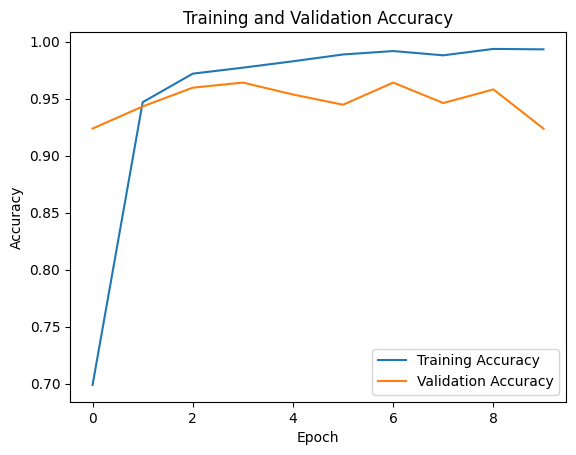

Imitating expert observations DONE!!!
19/19 [==============================] - 1s 35ms/step
Initial Best score:  0.2004450660584223
Training completed for rollout 2

############### Testing learned model ###############
Reward: 142.0, Expected Reward: 155
19/19 [==============================] - 1s 36ms/step


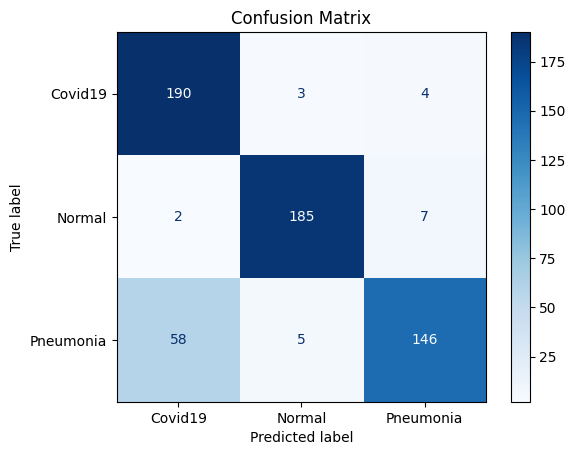

Accuracy: 0.8683333333333333
Precision: 0.8683333333333333
F1 Score: 0.8683333333333333
AUC-ROC Score: 0.90125
Confusion Matrix:
[[190   3   4]
 [  2 185   7]
 [ 58   5 146]]
*************** Testing learned model done ***************



############### Rollout: 3 of 10 ###############
Value of beta: 0.81
5/5 [==============================] - 0s 37ms/step
expert's accuracy = 0.9548387096774194
{'0': 47, '1': 66, '2': 42}
Training for rollout 3 with 3498 of training data
Imitating expert observations....
Default class weight: {0: 1158, 1: 1174, 2: 1166}
Epoch 1/10
44/44 [==============================] - 9s 196ms/step - loss: 1915.9335 - accuracy: 0.6973 - val_loss: 1.5438 - val_accuracy: 0.8757
Epoch 2/10
44/44 [==============================] - 4s 87ms/step - loss: 187.4329 - accuracy: 0.9446 - val_loss: 1.4730 - val_accuracy: 0.9257
Epoch 3/10
44/44 [==============================] - 4s 87ms/step - loss: 88.7277 - accuracy: 0.9732 - val_loss: 1.4753 - val_accuracy: 0.9300
Epoch 4/10


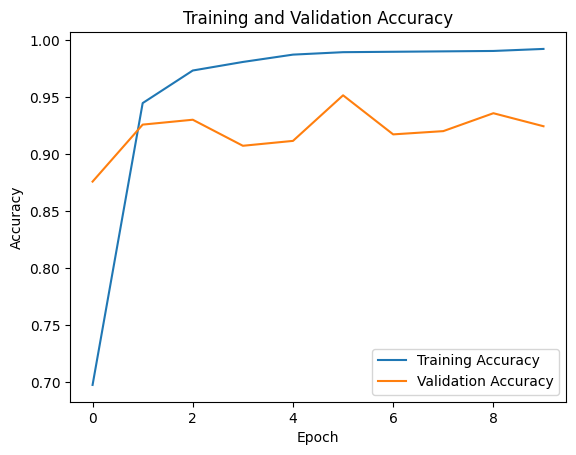

Imitating expert observations DONE!!!
19/19 [==============================] - 1s 36ms/step
Initial Best score:  0.176143651379939
Training completed for rollout 3

############### Testing learned model ###############
Reward: 137.0, Expected Reward: 155
19/19 [==============================] - 1s 36ms/step


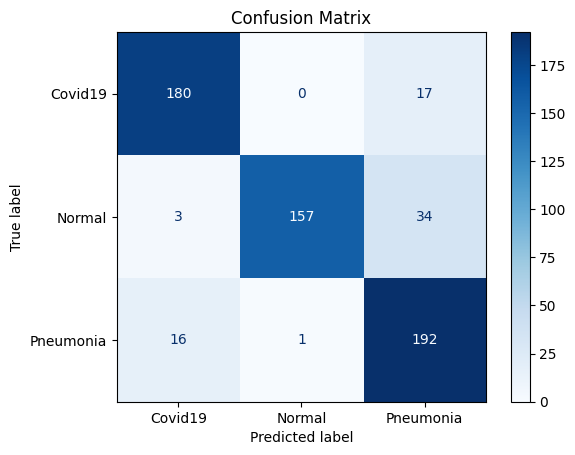

Accuracy: 0.8816666666666667
Precision: 0.8816666666666667
F1 Score: 0.8816666666666667
AUC-ROC Score: 0.91125
Confusion Matrix:
[[180   0  17]
 [  3 157  34]
 [ 16   1 192]]
*************** Testing learned model done ***************



############### Rollout: 4 of 10 ###############
Value of beta: 0.7290000000000001
5/5 [==============================] - 0s 35ms/step
expert's accuracy = 0.9806451612903225
{'0': 53, '1': 52, '2': 50}
Training for rollout 4 with 3653 of training data
Imitating expert observations....
Default class weight: {0: 1208, 1: 1226, 2: 1219}
Epoch 1/10
46/46 [==============================] - 7s 135ms/step - loss: 1831.5378 - accuracy: 0.6889 - val_loss: 1.5651 - val_accuracy: 0.8687
Epoch 2/10
46/46 [==============================] - 4s 84ms/step - loss: 161.2987 - accuracy: 0.9589 - val_loss: 1.5300 - val_accuracy: 0.8933
Epoch 3/10
46/46 [==============================] - 4s 85ms/step - loss: 78.8030 - accuracy: 0.9754 - val_loss: 1.5734 - val_accuracy: 0.89

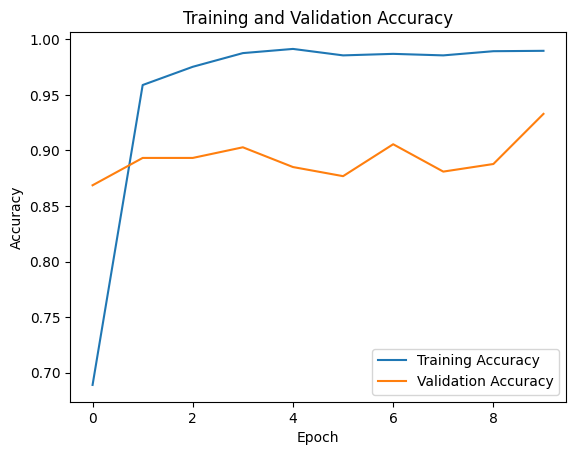

Imitating expert observations DONE!!!
19/19 [==============================] - 1s 36ms/step
Initial Best score:  0.14767540047885033
Training completed for rollout 4

############### Testing learned model ###############
Reward: 134.0, Expected Reward: 155
19/19 [==============================] - 1s 36ms/step


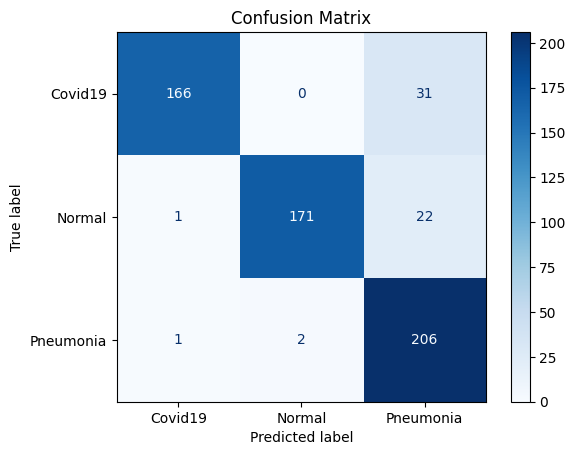

Accuracy: 0.905
Precision: 0.905
F1 Score: 0.905
AUC-ROC Score: 0.92875
Confusion Matrix:
[[166   0  31]
 [  1 171  22]
 [  1   2 206]]
*************** Testing learned model done ***************



############### Rollout: 5 of 10 ###############
Value of beta: 0.6561
5/5 [==============================] - 0s 36ms/step
expert's accuracy = 0.9870967741935484
{'0': 50, '1': 49, '2': 56}
Training for rollout 5 with 3808 of training data
Imitating expert observations....
Default class weight: {0: 1257, 1: 1276, 2: 1275}
Epoch 1/10
48/48 [==============================] - 7s 126ms/step - loss: 1732.9377 - accuracy: 0.6940 - val_loss: 1.5229 - val_accuracy: 0.9016
Epoch 2/10
48/48 [==============================] - 4s 85ms/step - loss: 176.4941 - accuracy: 0.9478 - val_loss: 1.5675 - val_accuracy: 0.8885
Epoch 3/10
48/48 [==============================] - 4s 85ms/step - loss: 92.2424 - accuracy: 0.9734 - val_loss: 1.7951 - val_accuracy: 0.8215
Epoch 4/10
48/48 [==============================

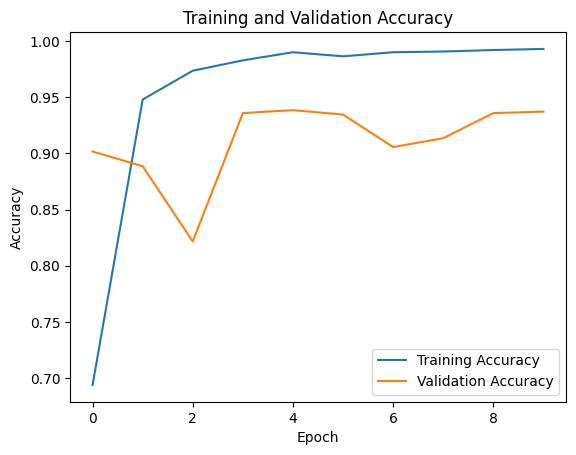

Imitating expert observations DONE!!!
19/19 [==============================] - 1s 35ms/step
Initial Best score:  0.1393573202329743
Training completed for rollout 5

############### Testing learned model ###############
Reward: 138.0, Expected Reward: 155
19/19 [==============================] - 1s 35ms/step


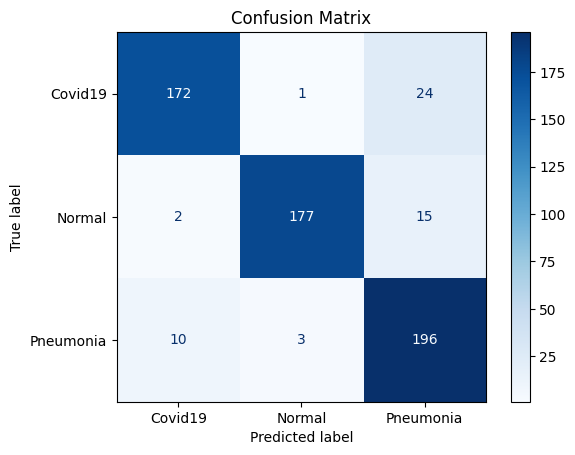

Accuracy: 0.9083333333333333
Precision: 0.9083333333333333
F1 Score: 0.9083333333333333
AUC-ROC Score: 0.93125
Confusion Matrix:
[[172   1  24]
 [  2 177  15]
 [ 10   3 196]]
*************** Testing learned model done ***************



############### Rollout: 6 of 10 ###############
Value of beta: 0.5904900000000001
5/5 [==============================] - 0s 39ms/step
expert's accuracy = 0.9419354838709677
{'0': 52, '1': 52, '2': 51}
Training for rollout 6 with 3963 of training data
Imitating expert observations....
Default class weight: {0: 1303, 1: 1329, 2: 1331}
Epoch 1/10
50/50 [==============================] - 8s 132ms/step - loss: 1681.6484 - accuracy: 0.7325 - val_loss: 1.5331 - val_accuracy: 0.8815
Epoch 2/10
50/50 [==============================] - 4s 88ms/step - loss: 193.1409 - accuracy: 0.9451 - val_loss: 1.6009 - val_accuracy: 0.8739
Epoch 3/10
50/50 [==============================] - 4s 87ms/step - loss: 95.9625 - accuracy: 0.9751 - val_loss: 1.5467 - val_accuracy: 0.90

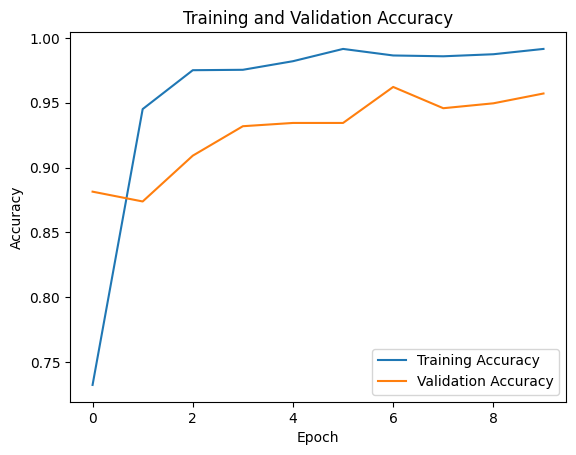

Imitating expert observations DONE!!!
19/19 [==============================] - 1s 36ms/step
Initial Best score:  0.0576002147561754
Training completed for rollout 6

############### Testing learned model ###############
Reward: 137.0, Expected Reward: 155
19/19 [==============================] - 1s 36ms/step


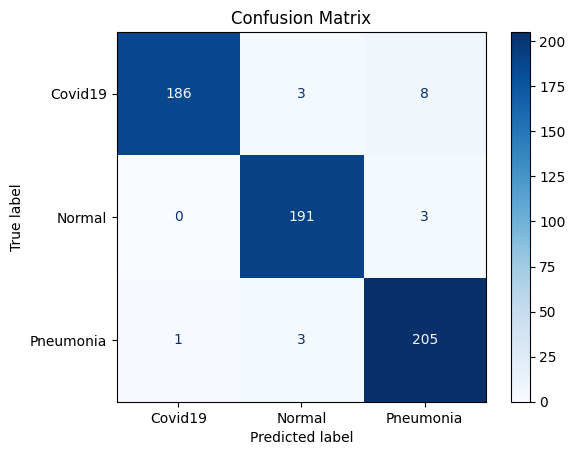

Accuracy: 0.97
Precision: 0.97
F1 Score: 0.97
AUC-ROC Score: 0.9775
Confusion Matrix:
[[186   3   8]
 [  0 191   3]
 [  1   3 205]]
*************** Testing learned model done ***************



############### Rollout: 7 of 10 ###############
Value of beta: 0.531441
5/5 [==============================] - 0s 36ms/step
expert's accuracy = 0.9483870967741935
{'0': 53, '1': 50, '2': 52}
Training for rollout 7 with 4118 of training data
Imitating expert observations....
Default class weight: {0: 1352, 1: 1378, 2: 1388}
Epoch 1/10
52/52 [==============================] - 10s 171ms/step - loss: 1966.9456 - accuracy: 0.7171 - val_loss: 1.5122 - val_accuracy: 0.9029
Epoch 2/10
52/52 [==============================] - 5s 89ms/step - loss: 178.7702 - accuracy: 0.9529 - val_loss: 1.4108 - val_accuracy: 0.9381
Epoch 3/10
52/52 [==============================] - 5s 88ms/step - loss: 96.0252 - accuracy: 0.9733 - val_loss: 1.4056 - val_accuracy: 0.9587
Epoch 4/10
52/52 [==============================]

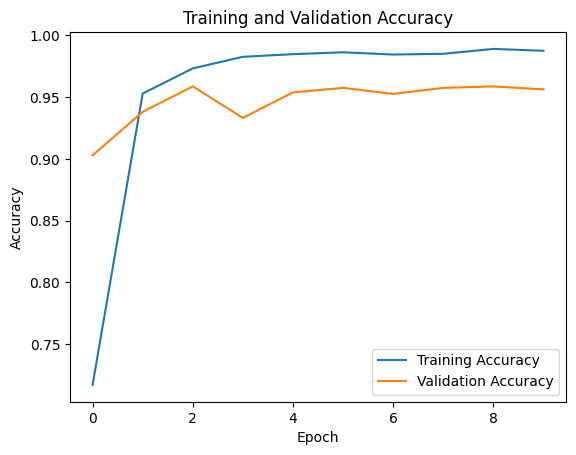

Imitating expert observations DONE!!!
19/19 [==============================] - 1s 35ms/step
Initial Best score:  0.06611925051290274
Training completed for rollout 7

############### Testing learned model ###############
Reward: 147.0, Expected Reward: 155
19/19 [==============================] - 1s 35ms/step


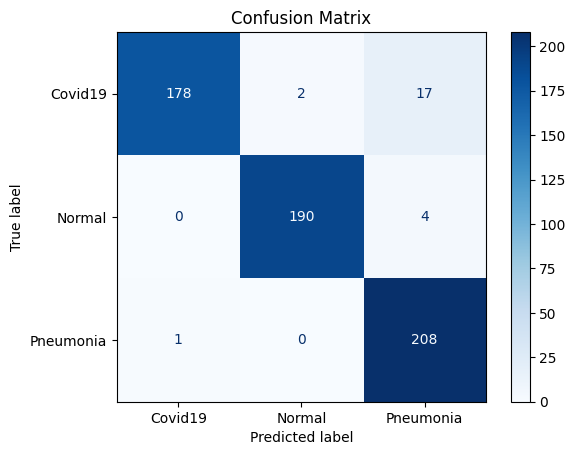

Accuracy: 0.96
Precision: 0.96
F1 Score: 0.96
AUC-ROC Score: 0.97
Confusion Matrix:
[[178   2  17]
 [  0 190   4]
 [  1   0 208]]
*************** Testing learned model done ***************



############### Rollout: 8 of 10 ###############
Value of beta: 0.4782969000000001
5/5 [==============================] - 0s 35ms/step
expert's accuracy = 0.9612903225806452
{'0': 50, '1': 46, '2': 59}
Training for rollout 8 with 4273 of training data
Imitating expert observations....
Default class weight: {0: 1398, 1: 1422, 2: 1453}
Epoch 1/10
54/54 [==============================] - 8s 141ms/step - loss: 1868.8997 - accuracy: 0.6934 - val_loss: 1.4772 - val_accuracy: 0.9357
Epoch 2/10
54/54 [==============================] - 5s 87ms/step - loss: 183.7145 - accuracy: 0.9544 - val_loss: 1.4130 - val_accuracy: 0.9404
Epoch 3/10
54/54 [==============================] - 5s 87ms/step - loss: 136.6091 - accuracy: 0.9672 - val_loss: 1.4510 - val_accuracy: 0.9579
Epoch 4/10
54/54 [=======================

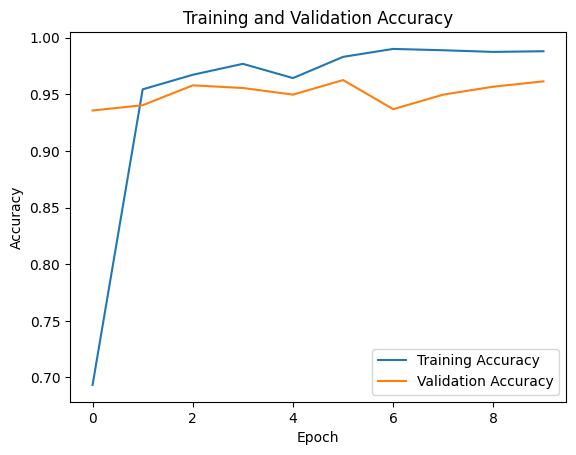

Imitating expert observations DONE!!!
19/19 [==============================] - 1s 35ms/step
Initial Best score:  0.05899716494718563
Training completed for rollout 8

############### Testing learned model ###############
Reward: 145.0, Expected Reward: 155
19/19 [==============================] - 1s 35ms/step


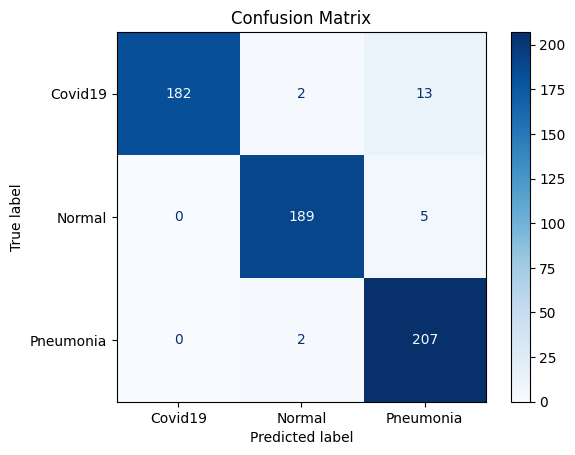

Accuracy: 0.9633333333333334
Precision: 0.9633333333333334
F1 Score: 0.9633333333333334
AUC-ROC Score: 0.9725
Confusion Matrix:
[[182   2  13]
 [  0 189   5]
 [  0   2 207]]
*************** Testing learned model done ***************



############### Rollout: 9 of 10 ###############
Value of beta: 0.4304672100000001
5/5 [==============================] - 0s 35ms/step
expert's accuracy = 0.9483870967741935
{'0': 50, '1': 53, '2': 52}
Training for rollout 9 with 4428 of training data
Imitating expert observations....
Default class weight: {0: 1446, 1: 1471, 2: 1511}
Epoch 1/10
56/56 [==============================] - 6s 95ms/step - loss: 2243.0564 - accuracy: 0.7013 - val_loss: 1.5244 - val_accuracy: 0.8770
Epoch 2/10
56/56 [==============================] - 5s 86ms/step - loss: 231.7379 - accuracy: 0.9424 - val_loss: 1.4616 - val_accuracy: 0.9108
Epoch 3/10
56/56 [==============================] - 5s 86ms/step - loss: 150.8958 - accuracy: 0.9602 - val_loss: 1.3906 - val_accuracy: 0.951

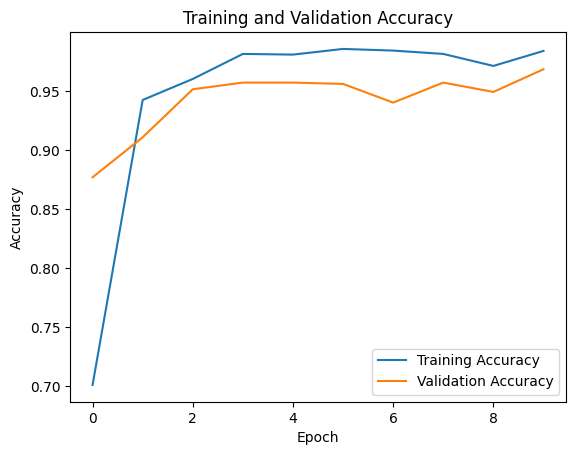

Imitating expert observations DONE!!!
19/19 [==============================] - 1s 37ms/step
Initial Best score:  0.05544031004041192
Training completed for rollout 9

############### Testing learned model ###############
Reward: 147.0, Expected Reward: 155
19/19 [==============================] - 1s 36ms/step


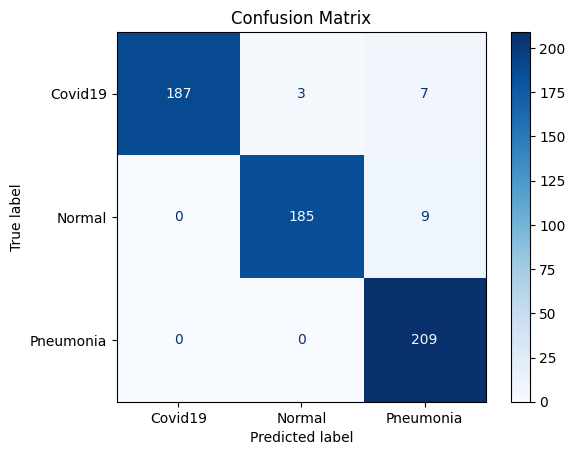

Accuracy: 0.9683333333333334
Precision: 0.9683333333333334
F1 Score: 0.9683333333333334
AUC-ROC Score: 0.97625
Confusion Matrix:
[[187   3   7]
 [  0 185   9]
 [  0   0 209]]
*************** Testing learned model done ***************



############### Rollout: 10 of 10 ###############
Value of beta: 0.3874204890000001
1/1 [==============================] - 0s 22ms/step
expert's accuracy = 1.0
{'0': 2, '1': 2, '2': 1}
Training for rollout 10 with 4433 of training data
Imitating expert observations....
Default class weight: {0: 1448, 1: 1473, 2: 1512}
Epoch 1/10
56/56 [==============================] - 9s 156ms/step - loss: 1849.0874 - accuracy: 0.6988 - val_loss: 1.5184 - val_accuracy: 0.9143
Epoch 2/10
56/56 [==============================] - 5s 85ms/step - loss: 229.3413 - accuracy: 0.9433 - val_loss: 1.4270 - val_accuracy: 0.9504
Epoch 3/10
56/56 [==============================] - 5s 85ms/step - loss: 126.2737 - accuracy: 0.9695 - val_loss: 1.4888 - val_accuracy: 0.9414
Epoch 4/10
5

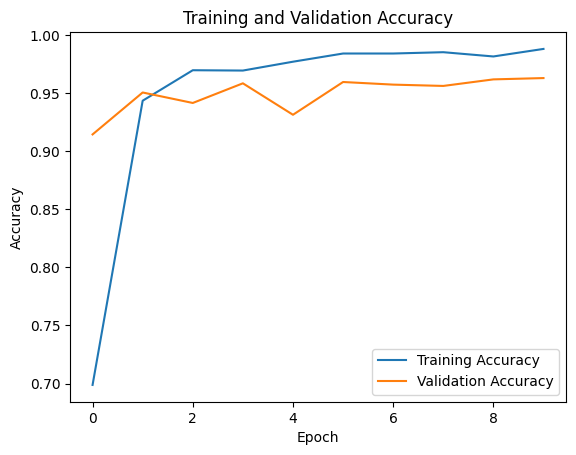

Imitating expert observations DONE!!!
19/19 [==============================] - 1s 36ms/step
Initial Best score:  0.0650270641539566
Training completed for rollout 10

############### Testing learned model ###############
Reward: 5.0, Expected Reward: 5
19/19 [==============================] - 1s 36ms/step


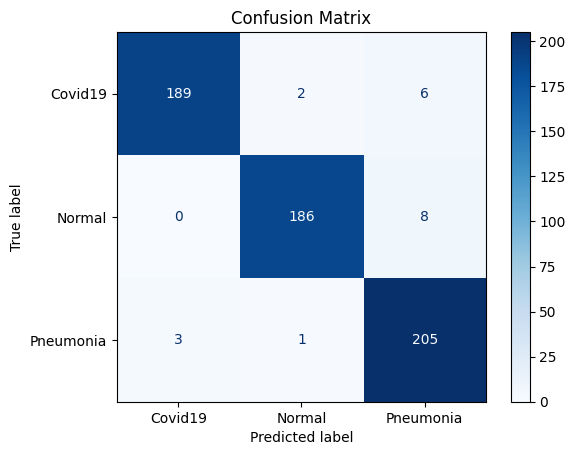

Accuracy: 0.9666666666666667
Precision: 0.9666666666666667
F1 Score: 0.9666666666666667
AUC-ROC Score: 0.9750000000000001
Confusion Matrix:
[[189   2   6]
 [  0 186   8]
 [  3   1 205]]
*************** Testing learned model done ***************





In [28]:
best_learned_policy = dagger.main()

In [29]:
print("Best learned policy is: {}".format(best_learned_policy))

Best learned policy is: ./models/learned_policy_model_expert_rollout_10.h5
